# Strategy 1: Borrowing interest rate based strategy

_Feedback from previous notebook_

Get a heatmap of avg SR for each coin

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as mtick
from common_models import DataSource, Trade, StrategySummary
from datetime import datetime, timedelta, UTC
from typing import Dict, List
import json
import requests
from utils import load_data, BINANCE_DOWNLOAD_FILE_NAME
from pathlib import Path
%matplotlib inline

In [2]:
# Change it to `DataSource.LIVE` to pull updated data from Binance
data_source = DataSource.LOCAL

In [3]:
df_all = None
if data_source == DataSource.LOCAL:
    if Path(BINANCE_DOWNLOAD_FILE_NAME).exists():
        df_all = pd.read_csv(BINANCE_DOWNLOAD_FILE_NAME)
    else:
        print("Local data file not found!")
if not df_all:
    from binance_secrets import api_key, api_secret
    assets = [
        "BTC",
        "ETH",
        "SOL",
        "BNB",
        "XRP",
        "ADA",
        "AVAX",
        "DOGE",
        "DOT",
        "TRX",
        "LINK",
        "MATIC",
        "SHIB",
        "LTC",
    ]
    df_all = load_data(
        api_key=api_key,
        api_secret=api_secret,
        interest_rate_assets=["USDT"] + assets,
        price_assets=[
            f"{a}USDT" for a in assets
        ],
        start_date=datetime(2023, 3, 1),
        end_date=datetime(2023, 12, 20))

Local data file not found!


Getting Prices: 100%|█████████████████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


Saving downloaded data...


In [4]:
df_all.columns

Index(['USDT', 'BTC', 'ETH', 'SOL', 'BNB', 'XRP', 'ADA', 'AVAX', 'DOGE', 'DOT',
       'TRX', 'LINK', 'MATIC', 'SHIB', 'LTC', 'BTCUSDT_open', 'BTCUSDT_high',
       'BTCUSDT_low', 'BTCUSDT_close', 'ETHUSDT_open', 'ETHUSDT_high',
       'ETHUSDT_low', 'ETHUSDT_close', 'SOLUSDT_open', 'SOLUSDT_high',
       'SOLUSDT_low', 'SOLUSDT_close', 'BNBUSDT_open', 'BNBUSDT_high',
       'BNBUSDT_low', 'BNBUSDT_close', 'XRPUSDT_open', 'XRPUSDT_high',
       'XRPUSDT_low', 'XRPUSDT_close', 'ADAUSDT_open', 'ADAUSDT_high',
       'ADAUSDT_low', 'ADAUSDT_close', 'AVAXUSDT_open', 'AVAXUSDT_high',
       'AVAXUSDT_low', 'AVAXUSDT_close', 'DOGEUSDT_open', 'DOGEUSDT_high',
       'DOGEUSDT_low', 'DOGEUSDT_close', 'DOTUSDT_open', 'DOTUSDT_high',
       'DOTUSDT_low', 'DOTUSDT_close', 'TRXUSDT_open', 'TRXUSDT_high',
       'TRXUSDT_low', 'TRXUSDT_close', 'LINKUSDT_open', 'LINKUSDT_high',
       'LINKUSDT_low', 'LINKUSDT_close', 'MATICUSDT_open', 'MATICUSDT_high',
       'MATICUSDT_low', 'MATICUSDT_close', 'S

In [5]:
def generate_indicator(interest_rate_currency: str, rolling_window: int) -> pd.Series:
    """Generate Z Score indicator
    """
    rolling = df_all[interest_rate_currency].rolling(rolling_window)
    return ((df_all[interest_rate_currency] - rolling.mean().shift(1)) / rolling.std(ddof=0).shift(1)).rename("indicator")

In [6]:
def generate_signal(indicator: pd.Series, threshold: float) -> pd.Series:
    """Convert indicator into signals
    """
    return (indicator > threshold).rename("signal")

In [13]:
def run_strategy(starting_capital: int, interest_rate_currency: str, symbol: str, rolling_window: int, threshold: float, risk_free_rate: float, verbose: bool = False):
    indicator = generate_indicator(interest_rate_currency=interest_rate_currency, rolling_window=rolling_window)
    signal = generate_signal(indicator, threshold=threshold)
    close_col = f"{symbol}_close"

    _df = df_all[[c for c in df_all.columns if (c.startswith(symbol) and len(c) > len(symbol))]]
    _df = _df.join(signal).dropna(subset=["signal", close_col])

    if verbose:
        print(f"Date Range: {_df.index.min()} till {_df.index.max()}")
        print(f"No. of Trading Days: {len(_df)}")

    cash = starting_capital
    position = 0

    opening_cash = []
    opening_position = []
    closing_cash = []
    closing_position = []

    trades = []

    for id, row in _df[["signal", close_col]].iterrows():
        opening_cash.append(cash)
        opening_position.append(position)
        if row["signal"] and position == 0:
            amount = cash
            unit = amount / row[close_col]
            position += unit
            cash -= amount
            trade = Trade(
                date=id,
                btc_close_price=row[close_col],
                trade_type=True,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        elif (not row["signal"]) and position > 0:
            unit = position
            amount = unit * row[close_col]
            position -= unit
            cash += amount
            trade = Trade(
                date=id,
                btc_close_price=row[close_col],
                trade_type=False,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        closing_cash.append(cash)
        closing_position.append(position)

    
    _df["opening_cash"] = opening_cash
    _df["opening_position"] = opening_position
    _df["closing_cash"] = closing_cash
    _df["closing_position"] = closing_position
    
    _df["closing_value"] = _df["closing_cash"] + _df["closing_position"] * _df[close_col]
    _df["return"] = _df["closing_value"].pct_change()
    _df["excess_return"] = _df["return"] - risk_free_rate
    _df["drawdown_pct"] = 1 - _df["closing_value"] / _df["closing_value"].expanding().max()
    _df["drawdown_period"] = _df["drawdown_pct"].groupby((_df["drawdown_pct"] == 0).cumsum()).cumcount()

    perf = StrategySummary(
        start_date=_df.index[0],
        end_date=_df.index[-1],
        starting_capital=starting_capital,
        trades=trades,
        total_pnl=_df["closing_value"].iloc[-1] - starting_capital,
        total_pnl_pct=_df["closing_value"].iloc[-1] / starting_capital - 1,
        sharpe_ratio=(_df['excess_return'].mean() / _df['excess_return'].std()) if len(trades) > 0 else np.nan,
        days_in_market=(_df["closing_position"] > 0).sum(),
        days_in_market_pct=(_df["closing_position"] > 0).mean(),
        portfolio_value_timeline=_df["closing_value"],
        max_drawdown_pct=_df["drawdown_pct"].max(),
        max_drawdown_period=_df["drawdown_period"].max(),
        drawdown_period_timeline=_df["drawdown_period"],
        watermark_timeline=_df["drawdown_pct"]
    )
    return perf

In [8]:
time_period = 365 * 24 # 1Y to hours
risk_free_rate = .0494 / time_period # 1Y T Bill

In [9]:
look_back_period_limit = len(df_all) // 10
look_back_period_limit

705

In [16]:
_ = 2
windows = []
while _ < look_back_period_limit:
    windows.append(_)
    _ *= 2
windows

[2, 4, 8, 16, 32, 64, 128, 256, 512]

In [17]:
thresholds = np.linspace(0, 2.5, 11)
thresholds

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ])

In [35]:
# thresholds = [0, 1, 2, 4, 8, 16, 32]
avg_sr = dict()
for symbol in tqdm([
    "BTC",
    "ETH",
    "SOL",
    "BNB",
    "XRP",
    "ADA",
    "AVAX",
    "DOGE",
    "DOT",
    "TRX",
    "LINK",
    "MATIC",
    "SHIB",
    "LTC",
]):
    interest_rate_currency = "USDT"
    avg_sr[symbol] = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        avg_sr[symbol].extend(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    avg_sr[symbol] = np.nanmean(avg_sr[symbol])
avg_sr

100%|█████████████████████████████████████████████████████████████████████| 14/14 [02:12<00:00,  9.49s/it]


{'BTC': -0.0022484196063763855,
 'ETH': -0.008896294299403237,
 'SOL': 0.004939373011539371,
 'BNB': -0.013890131355852804,
 'XRP': -0.007770183838287433,
 'ADA': -0.002157509573284153,
 'AVAX': 0.004631456620922754,
 'DOGE': -0.007068142692046165,
 'DOT': -0.0075991894405858015,
 'TRX': -0.0014795986788276965,
 'LINK': -0.005484980725324946,
 'MATIC': -0.01538205613113898,
 'SHIB': -0.008447993821520535,
 'LTC': -0.007061162295733077}

Text(0.5, 80.7222222222222, 'Average Sharpe Ratio')

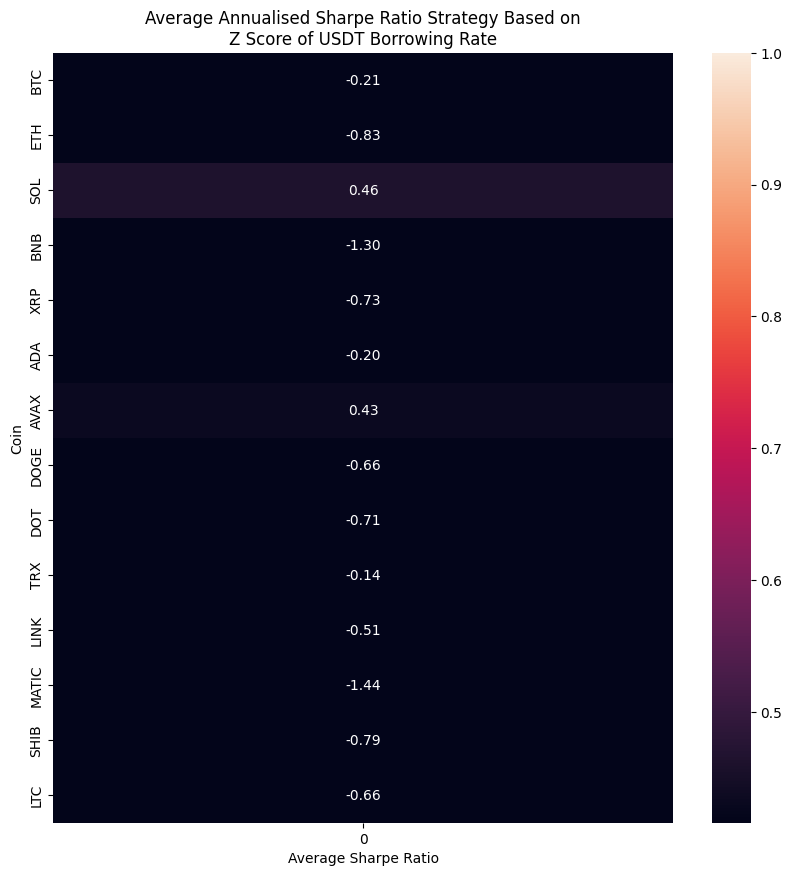

In [37]:
df_sr = pd.Series(avg_sr) * np.sqrt(time_period)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_sr.to_frame().astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max(), robust=True)
ax.set_title(f"Average Annualised Sharpe Ratio Strategy Based on\nZ Score of USDT Borrowing Rate")
ax.set_ylabel("Coin")
ax.set_xlabel("Average Sharpe Ratio")

In [19]:
# thresholds = [0, 1, 2, 4, 8, 16, 32]
avg_sr = dict()
for symbol in tqdm([
    "BTC",
    "ETH",
    "SOL",
    "BNB",
    "XRP",
    "ADA",
    "AVAX",
    "DOGE",
    "DOT",
    "TRX",
    "LINK",
    "MATIC",
    "SHIB",
    "LTC",
]):
    interest_rate_currency = symbol
    avg_sr[symbol] = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        avg_sr[symbol].extend(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    avg_sr[symbol] = np.nanmean(avg_sr[symbol])
avg_sr

100%|█████████████████████████████████████████████████████████████████████| 14/14 [02:12<00:00,  9.47s/it]


{'BTC': 0.007403352301980443,
 'ETH': -0.0022829470310078144,
 'SOL': 0.018358619087247636,
 'BNB': -0.01593130523996013,
 'XRP': 0.0035718424082376156,
 'ADA': 0.020100474345526118,
 'AVAX': 0.005197135039010597,
 'DOGE': 0.0054271347370982055,
 'DOT': 0.018513461317638393,
 'TRX': 0.012956751253581563,
 'LINK': 0.00400069629574855,
 'MATIC': 0.0028695367173207967,
 'SHIB': 0.015788590398583918,
 'LTC': 0.0030845452633554153}

Text(0.5, 80.7222222222222, 'Average Sharpe Ratio')

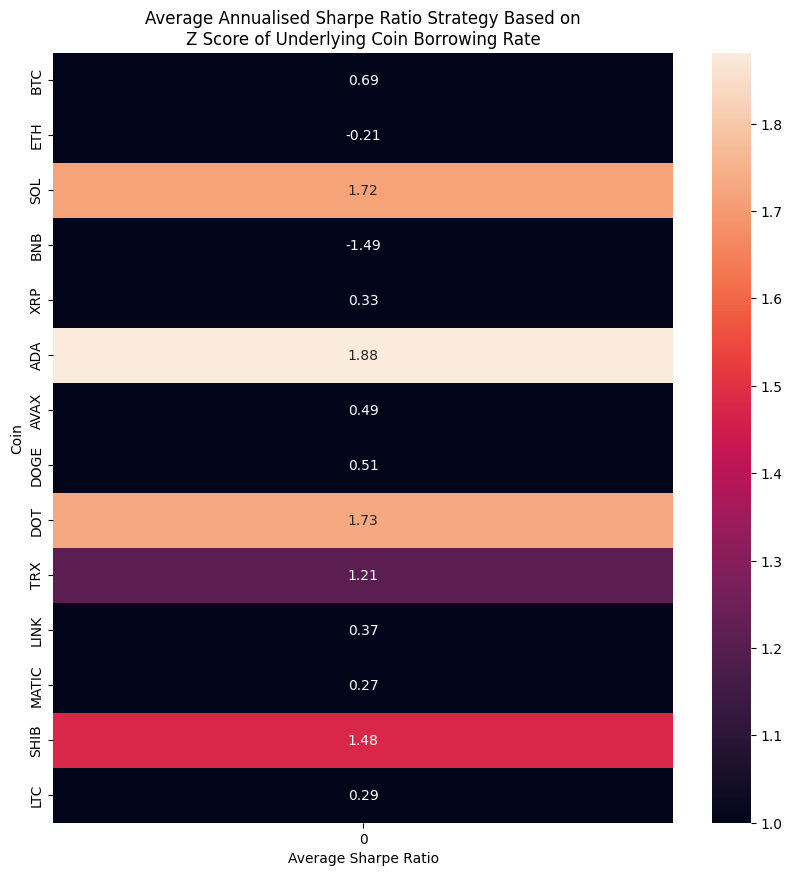

In [34]:
df_sr = pd.Series(avg_sr) * np.sqrt(time_period)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_sr.to_frame().astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max(), robust=True)
ax.set_title(f"Average Annualised Sharpe Ratio Strategy Based on\nZ Score of Underlying Coin Borrowing Rate")
ax.set_ylabel("Coin")
ax.set_xlabel("Average Sharpe Ratio")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


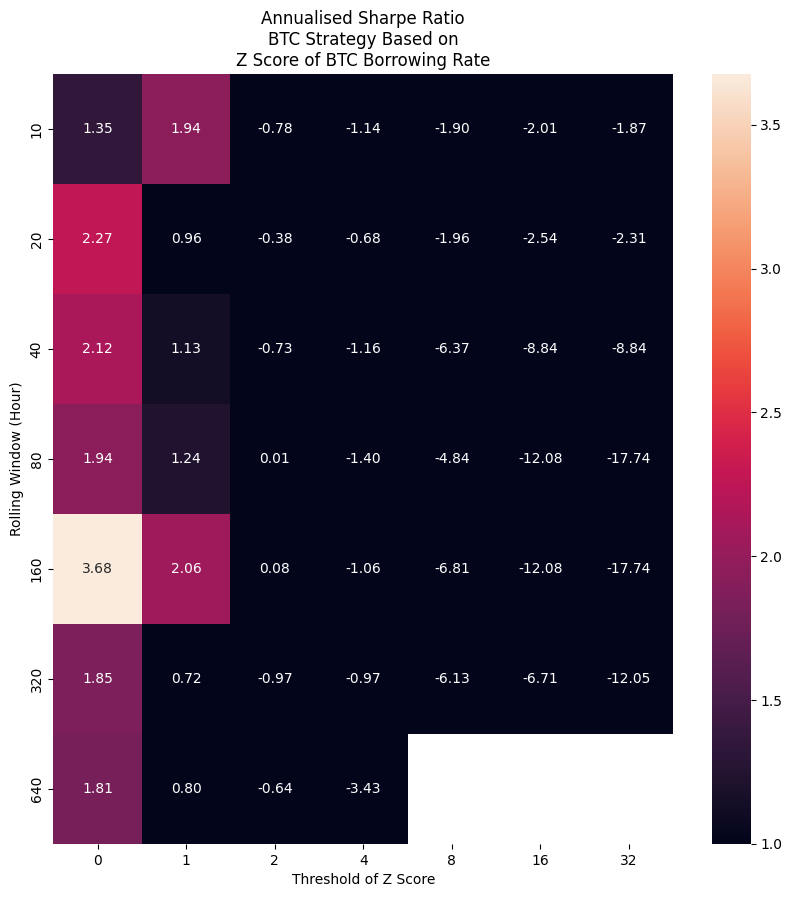

In [39]:
thresholds = [0, 1, 2, 4, 8, 16, 32]
windows = [10, 20, 40, 80, 160, 320, 640]
for symbol in tqdm([
    "BTC",
]):
    interest_rate_currency = symbol
    df_sr = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        df_sr.append(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
    ax.set_title(f"Annualised Sharpe Ratio\n{symbol} Strategy Based on\nZ Score of {interest_rate_currency} Borrowing Rate")
    ax.set_xlabel("Threshold of Z Score")
    ax.set_ylabel("Rolling Window (Hour)")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


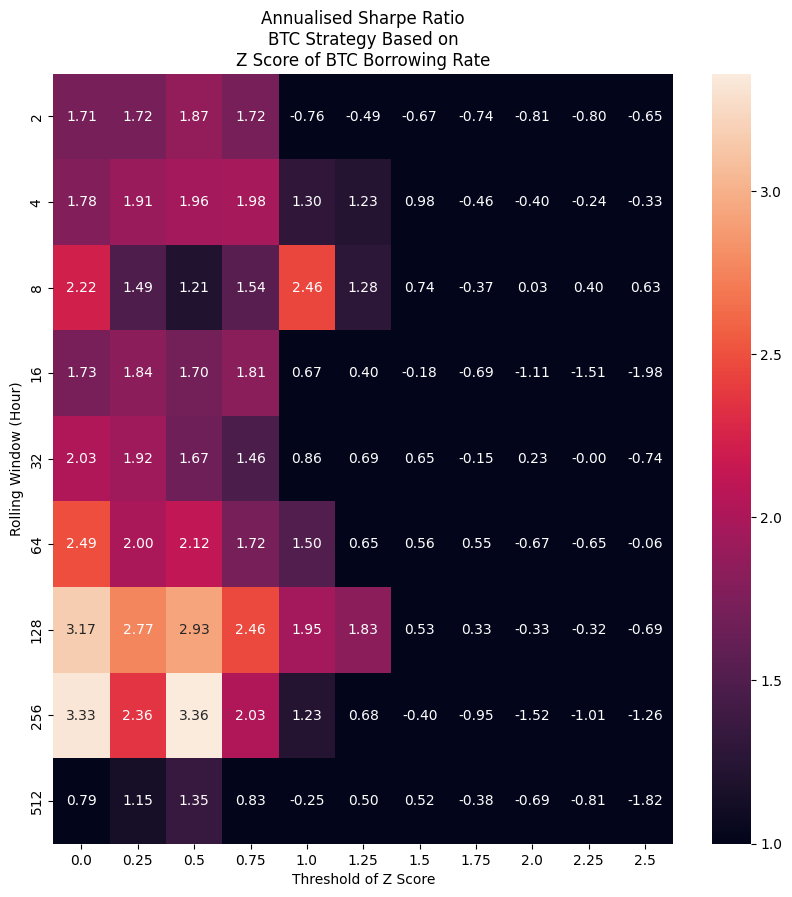

In [41]:
thresholds = np.linspace(0, 2.5, 11)
windows = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for symbol in tqdm([
    "BTC",
]):
    interest_rate_currency = symbol
    df_sr = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        df_sr.append(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
    ax.set_title(f"Annualised Sharpe Ratio\n{symbol} Strategy Based on\nZ Score of {interest_rate_currency} Borrowing Rate")
    ax.set_xlabel("Threshold of Z Score")
    ax.set_ylabel("Rolling Window (Hour)")